# LAB 8: Non-linear models

Objectives:
- Compare 
   - simple linear models
   - multilayer perceptrons -
   - linear models with pre-trained word vectors
- Relative performance with differing quantities of training data
    - Speed
    - Accuracy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [2]:
from sklearn.utils import resample

In [3]:
all_train = pd.read_csv("/data/ag_news_csv/train.csv", header=None)
all_test = pd.read_csv("/data/ag_news_csv/test.csv", header=None)

In [4]:
all_train.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Replace category numbers with category names

In [5]:
cats = [c.strip() for c in open("/data/ag_news_csv/classes.txt")]
all_train["cat"] = all_train[0].apply(lambda c: cats[c - 1])
all_test["cat"] = all_test[0].apply(lambda c: cats[c - 1])

In [6]:
cats

['World', 'Sports', 'Business', 'Sci/Tech']

In [7]:
all_train.head()

,0,1,2,cat
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business


Combine headline and summary into one text

In [8]:
all_train["text"] = all_train[1] + " " + all_train[2]
all_test["text"] = all_test[1] + " " + all_test[2]

In [9]:
all_train = all_train[["text", "cat"]]
all_test = all_test[["text", "cat"]]

In [68]:
df_list = []

In [10]:
all_train.head()

,text,cat
0,Wall St. Bears Claw Back Into the Black (Reute...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


In [11]:
len(all_train)

120000

In [12]:
len(all_test)

7600

Thin data to simulate a "very low train data" context. We'll keep the number of test examples at 1,000 but vary the number of training examples.

In [130]:
n_train = 5000
n_test = 1000

train = resample(
    all_train,
    replace=False,
    n_samples=n_train,
    stratify=all_train["cat"],
    random_state=99,
)
test = resample(
    all_test, replace=False, n_samples=n_test, stratify=all_test["cat"], random_state=57
)

---

## Random baseline

In [109]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [110]:
dummy = DummyClassifier()
dummy.fit(train["text"], train["cat"])
print(classification_report(test["cat"], dummy.predict(test["text"])))

              precision    recall  f1-score   support

    Business       0.25      1.00      0.40       250
    Sci/Tech       0.00      0.00      0.00       250
      Sports       0.00      0.00      0.00       250
       World       0.00      0.00      0.00       250

    accuracy                           0.25      1000
   macro avg       0.06      0.25      0.10      1000
weighted avg       0.06      0.25      0.10      1000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

## Linear classifier

In [111]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [112]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [131]:
train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [132]:
%%time
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier(random_state=321))
sgd.fit(train["tokens"], train["cat"])
print(classification_report(test["cat"], sgd.predict(test["tokens"])))

              precision    recall  f1-score   support

    Business       0.90      0.76      0.82       250
    Sci/Tech       0.82      0.87      0.84       250
      Sports       0.90      0.96      0.93       250
       World       0.85      0.87      0.86       250

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

CPU times: user 215 ms, sys: 38.8 ms, total: 254 ms
Wall time: 188 ms


Hyperparameter search

In [133]:
%%time
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__average": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1_weighted",
)

search.fit(train["tokens"], train["cat"])
search.best_score_, search.best_params_

CPU times: user 4.24 s, sys: 43.1 ms, total: 4.28 s
Wall time: 8.97 s


(0.8669789719479697,
 {'sgdclassifier__alpha': 0.008838876434219614,
  'sgdclassifier__average': False})

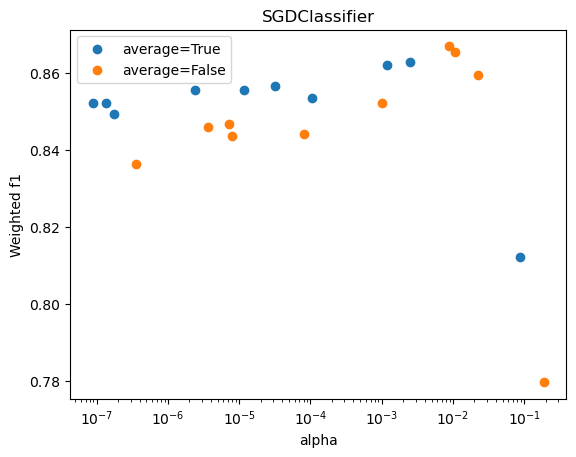

In [134]:
cv_results = pd.DataFrame(search.cv_results_)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==True")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==True")["mean_test_score"],
    label="average=True",
)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==False")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==False")["mean_test_score"],
    label="average=False",
)
plt.semilogx()
plt.title("SGDClassifier")
plt.xlabel("alpha")
plt.ylabel("Weighted f1")
plt.legend()
plt.show()

Best hyperparameter settings

In [135]:
sgd.set_params(**search.best_params_)
sgd.fit(train["tokens"], train["cat"])
print(classification_report(test["cat"], sgd.predict(test["tokens"])))

              precision    recall  f1-score   support

    Business       0.89      0.81      0.85       250
    Sci/Tech       0.82      0.86      0.84       250
      Sports       0.92      0.96      0.94       250
       World       0.91      0.91      0.91       250

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [137]:
sgd_accuracy = accuracy_score(test["cat"], sgd.predict(test["tokens"]))
sgd_time = 188/1000 + 8.97
sgd_time, sgd_accuracy

(9.158000000000001, 0.886)

---

## MLP

In [138]:
from sklearn.neural_network import MLPClassifier

You could try varying the size of the hidden layer. Also, this will get very expensive as you increase the amount of training data. At some point it might stop being practical!

In [139]:
%%time
mlp = make_pipeline(
    CountVectorizer(analyzer=identity),
    MLPClassifier(hidden_layer_sizes=(25,), max_iter=500, random_state=619),
)
mlp.fit(train["tokens"], train["cat"])
print(classification_report(test["cat"], mlp.predict(test["tokens"])))

              precision    recall  f1-score   support

    Business       0.84      0.84      0.84       250
    Sci/Tech       0.83      0.82      0.82       250
      Sports       0.94      0.96      0.95       250
       World       0.89      0.89      0.89       250

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

CPU times: user 23 s, sys: 8.8 s, total: 31.8 s
Wall time: 15.9 s


**Hyperparameter search**

In [146]:
%%time
search = RandomizedSearchCV(
    mlp,
    {
        "mlpclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1_weighted",
)

search.fit(train["tokens"], train["cat"])
search.best_score_, search.best_params_

CPU times: user 27.9 s, sys: 8.93 s, total: 36.9 s
Wall time: 23min 23s


(0.8692285084038909, {'mlpclassifier__alpha': 0.0009261924854586145})

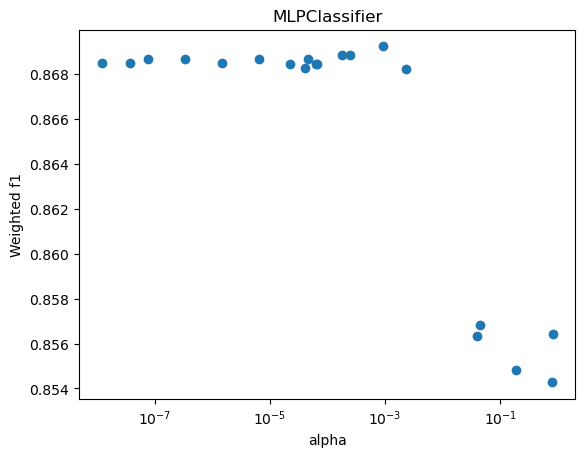

In [147]:
cv_results = pd.DataFrame(search.cv_results_)
plt.scatter(cv_results["param_mlpclassifier__alpha"], cv_results["mean_test_score"])
plt.semilogx()
plt.title("MLPClassifier")
plt.xlabel("alpha")
plt.ylabel("Weighted f1")
plt.show()

Best hyperparameter search

In [148]:
mlp.set_params(**search.best_params_)
mlp.fit(train["tokens"], train["cat"])
print(classification_report(test["cat"], mlp.predict(test["tokens"])))

              precision    recall  f1-score   support

    Business       0.84      0.84      0.84       250
    Sci/Tech       0.83      0.82      0.82       250
      Sports       0.94      0.96      0.95       250
       World       0.90      0.90      0.90       250

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [149]:
mlp_accuracy = accuracy_score(test["cat"], mlp.predict(test["tokens"]))
mlp_time = 15.9 + 23*60 + 23
mlp_time, mlp_accuracy

(1418.9, 0.878)

---

## Linear classifier + fasttext vectors

In [83]:
import fasttext
from sklearn.base import BaseEstimator, TransformerMixin

Loading the word vectors can be slow, so we'll check to see if they're already loaded first

In [59]:
try:
    cc_model
except NameError:
    cc_model = fasttext.load_model("/data/cc.en.100.bin")

Scikit-learn doesn't have support for pre-trained word vectors built in, but it's easy to create a simple vectorizer class.

In [61]:
class FasttextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.vstack([cc_model.get_sentence_vector(x) for x in X])

In [150]:
%%time
sgd_vec = make_pipeline(FasttextVectorizer(), SGDClassifier(random_state=1))
sgd_vec.fit(train["text"], train["cat"])
print(classification_report(test["cat"], sgd_vec.predict(test["text"])))

              precision    recall  f1-score   support

    Business       0.85      0.81      0.83       250
    Sci/Tech       0.83      0.84      0.83       250
      Sports       0.94      0.96      0.95       250
       World       0.89      0.91      0.90       250

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

CPU times: user 380 ms, sys: 30.7 ms, total: 411 ms
Wall time: 367 ms


Hyperparameter search

In [151]:
%%time
search = RandomizedSearchCV(
    sgd_vec,
    {
        "sgdclassifier__average": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=10,
    scoring="f1_weighted",
)

search.fit(train["text"], train["cat"])
search.best_score_, search.best_params_

CPU times: user 14.4 s, sys: 2.41 s, total: 16.8 s
Wall time: 12.7 s


(0.8772194301831284,
 {'sgdclassifier__alpha': 8.834143690982039e-08,
  'sgdclassifier__average': True})

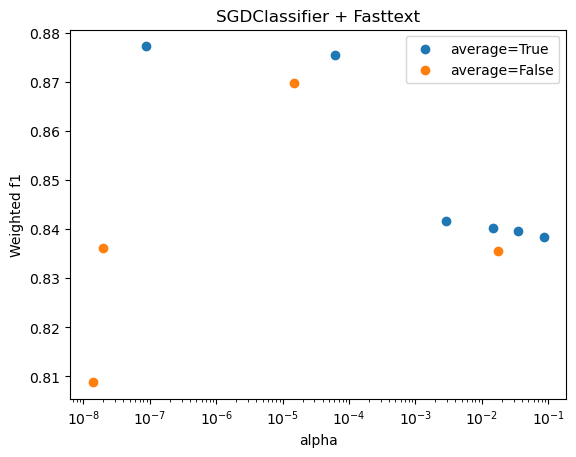

In [152]:
cv_results = pd.DataFrame(search.cv_results_)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==True")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==True")["mean_test_score"],
    label="average=True",
)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==False")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==False")["mean_test_score"],
    label="average=False",
)
plt.semilogx()
plt.title("SGDClassifier + Fasttext")
plt.xlabel("alpha")
plt.ylabel("Weighted f1")
plt.legend()
plt.show()

Best hyperparameter settings

In [153]:
sgd_vec.set_params(**search.best_params_)
sgd_vec.fit(train["text"], train["cat"])
print(classification_report(test["cat"], sgd_vec.predict(test["text"])))

              precision    recall  f1-score   support

    Business       0.87      0.82      0.84       250
    Sci/Tech       0.83      0.85      0.84       250
      Sports       0.95      0.96      0.95       250
       World       0.90      0.91      0.90       250

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [154]:
sgd_vec_accuracy = accuracy_score(test["cat"], sgd_vec.predict(test["text"]))
sgd_vec_time = 367/1000 + 12.7
sgd_vec_time, sgd_vec_accuracy

(13.067, 0.886)

----

## Conclusions

Write your conclusions here. How do the three methods compare, in speed and in accuracy, with different amount of training data? You will probably find that increasing the training set size improves the simple linear model more than it improves the others. Is there a point where the linear model outperforms MLPs and fasttext? Be specific and show your results as a table and/or graph showing training set size vs. performance for the three methods.

In [155]:
df_list.append([n_train, sgd_time, sgd_accuracy, mlp_time, mlp_accuracy, sgd_vec_time, sgd_vec_accuracy])
df_list

[[50, 1.9427, 0.487, 9.717, 0.528, 0.481, 0.733],
 [100, 2.0382, 0.561, 12.762, 0.611, 0.5960000000000001, 0.705],
 [500, 2.482, 0.75, 68.04, 0.79, 1.7424, 0.86],
 [1000, 1.413, 0.796, 167.2, 0.843, 3.136, 0.862],
 [5000, 9.158000000000001, 0.886, 1418.9, 0.878, 13.067, 0.886]]

**Comparisions**

In [156]:
import pandas as pd

In [157]:
df = pd.DataFrame(
    df_list, 
    columns = ["n_train", "sgd_time", "sgd_accuracy", "mlp_time", "mlp_accuracy", "sgd_vec_time", "sgd_vec_accuracy"]
)

In [158]:
df

,n_train,sgd_time,sgd_accuracy,mlp_time,mlp_accuracy,sgd_vec_time,sgd_vec_accuracy
0,50,1.9427,0.487,9.717,0.528,0.4810,0.733
1,100,2.0382,0.561,12.762,0.611,0.5960,0.705
2,500,2.4820,0.750,68.040,0.790,1.7424,0.860
3,1000,1.4130,0.796,167.200,0.843,3.1360,0.862
4,5000,9.1580,0.886,1418.900,0.878,13.0670,0.886


I have varied number of training samples from 50 to 5000 but did not change the layers and layer sizes in MLP model as it would be computationally more expensive. Number of test samples were kept constant at 1000.

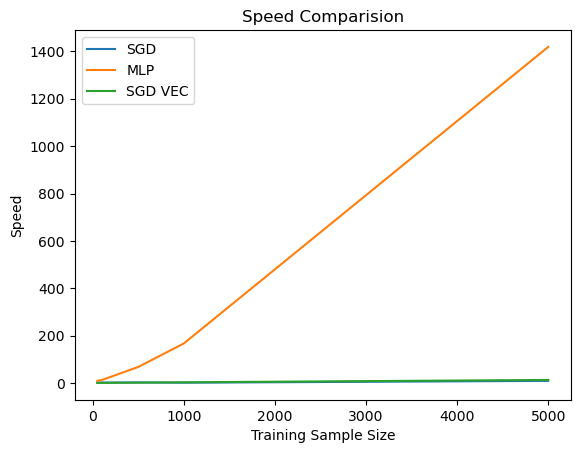

In [166]:
plt.plot(df["n_train"], df["sgd_time"])
plt.plot(df["n_train"], df["mlp_time"])
plt.plot(df["n_train"], df["sgd_vec_time"])
plt.title("Speed Comparision")
plt.xlabel("Training Sample Size")
plt.ylabel("Speed")
plt.legend(["SGD", "MLP", "SGD VEC"])
plt.show()

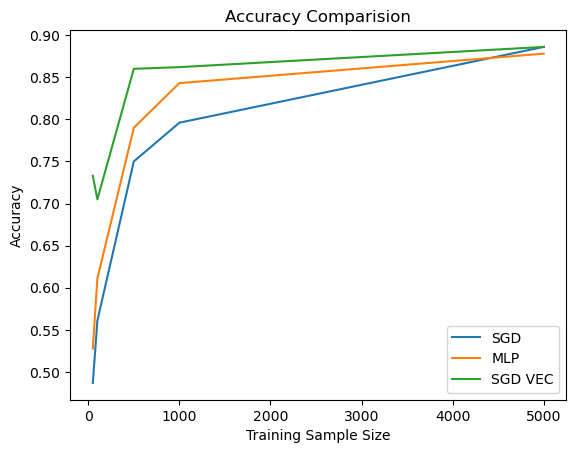

In [165]:
plt.plot(df["n_train"], df["sgd_accuracy"])
plt.plot(df["n_train"], df["mlp_accuracy"])
plt.plot(df["n_train"], df["sgd_vec_accuracy"])
plt.title("Accuracy Comparision")
plt.xlabel("Training Sample Size")
plt.ylabel("Accuracy")
plt.legend(["SGD", "MLP", "SGD VEC"])
plt.show()

At the beginning when number of training samples are at 50, Accuracy of the linear model with fasttextvector was better. While all the three models took relatively similar amount of time to train and tune.
Accuracies of the linear model and MLP model are low and comparable, but better than the baseline dummy.

When the number of training samples were increased gradually, the Linear model increased constantly.

Also MLP model was getting better in accuracy when the training data is increased.

SGD model with WordVectorizer already started off better (even though it took a small dip) and was always good compared to the other two but the rise is not that great comparably.

In the end, when number of training samples was at 5000, both the linear models had same accuracy of 88.6 percent with and without word vectorizer. but SGD with wordvec took more time when the training data started to increase past 1000.

MLP model eventually caught up, but it is tiny bit behind the other two at present, and may even catch or surpass them with the increase in training data, at a greater computation costs. The time taken to train and tune the MLP model has always been very large, not even in the comparable limits to other two. MLP model here might not make more sense as the linear models were also doing better, may stop to grow at certain point but are still easier and faster as compared.